# Building a ReAct AI Agent from scratch with LangGraph

Here we will build AI Agents with LangGraph from scratch.

Here we'll create a simple ReAct agent app that can search the web and check the weather. The app consists of an agent (LLM) and tools. As we interact with the app, we will first call the agent (LLM) to decide if we should use tools. Then we will run a loop:

- If the agent said to take an action (i.e. call tool), we'll run the tools and pass the results back to the agent
- If the agent did not ask to run tools, we will finish (respond to the user)

We will implement this in LangGraph completely from scratch step by step.


There will be three parts to this hands-on demo:

- Part I: Build a Basic Chatbot with LangGraph
- Part II: Build a simple ReAct Agent with LangGraph - LLM + Tools
- Part III: Build a multi-user conversational ReAct Agent with LangGraph

## Install OpenAI, and LangChain dependencies

Install the following httpx library version for compatibility with other libraries

In [1]:
!pip install httpx==0.27.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.16.1 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.27.2 which is incompatible.


In [2]:
!pip install langchain==0.2.0
!pip install langchain-openai==0.1.7
!pip install langchain-community==0.2.0
!pip install langgraph==0.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.7/973.7 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.1/397.1 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.8/311.8 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.1.2
    Uninstalling tenacity-9.1.2:
      Successfully uninstalled tenacity-9.1.2
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.3.42
    Uninstalling langsmith-0.3.42:
      Successfully uninstalled langsmith-0.3.42
  Attempting uninstall: langchain-core
    Fo

## Setup Environment Variables

In [27]:
from google.colab import userdata
import os

os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

WEATHER_API_KEY = userdata.get('WEATHER_API_KEY')

## Part I: Build a Basic Chatbot with LangGraph

The first step will be to create a simple chatbot using LangGraph.

This chatbot will respond directly to user messages.

- We will start by creating a `StateGraph`. A `StateGraph` object defines the structure of our chatbot as a "state machine"
- `nodes` will represent the llm and functions our chatbot can call
- `edges` will specify how the bot should transition between these functions



In [5]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

class State(TypedDict):
    # Messages have the type "list"
    # The `add_messages` function in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

We've defined our `State` as a TypedDict with a single key: `messages`.

The `messages` key is annotated with the [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) function, which tells LangGraph to append new messages to the existing list, rather than overwriting it.

So now our graph knows two things:

1. Every `node` we define will receive the current `State` as input and return a value that updates that state.
2. `messages` will be _appended_ to the current list, rather than directly overwritten. This is communicated via the prebuilt [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) function in the `Annotated` syntax.

Next, we add a "`chatbot`" node.

Nodes represent units of work. They are typically regular python functions.

This is a simple node which will just send our messages to an LLM.

In [6]:
from langchain_openai import ChatOpenAI

chatgpt = ChatOpenAI(model="gpt-4o", temperature=0)


def chatbot(state: State):
    return {"messages": [chatgpt.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object
# this function will be called whenever the node is used.
graph_builder.add_node("chatbot", chatbot)

The `chatbot` node function takes the current `State` as input and returns an updated `messages` list.

This is the basic pattern for all LangGraph node functions.

The `add_messages` function in our `State` will append the LLM's response messages to whatever messages are already in the state.

Next, we add an `entry` point. This tells our graph **where to start its work** each time we run it.

In [7]:
graph_builder.set_entry_point("chatbot")

Similarly, we set a `finish` point. This instructs the graph **"any time this node is run, you can exit."**

In [8]:
graph_builder.set_finish_point("chatbot")

Now we will compile our graph by calling "`compile()`" on the graph builder.

This creates a "`CompiledGraph`" we can use invoke on our state.

In [9]:
graph = graph_builder.compile()

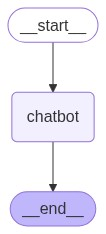

In [10]:
from IPython.display import Image, display, Markdown

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
prompt = """What is the fastest animal on land?"""
response = graph.invoke({"messages": ("user", prompt)})

In [12]:
response

{'messages': [HumanMessage(content='What is the fastest animal on land?', id='579b627f-23e8-4d9f-81d1-18e5c318d096'),
  AIMessage(content='The fastest animal on land is the cheetah. It can reach speeds of up to 60 to 70 miles per hour (97 to 113 kilometers per hour) in short bursts covering distances up to 1,500 feet (460 meters), and it can accelerate from 0 to 60 miles per hour in just a few seconds.', response_metadata={'token_usage': {'completion_tokens': 70, 'prompt_tokens': 15, 'total_tokens': 85, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_07871e2ad8', 'finish_reason': 'stop', 'logprobs': None}, id='run-9f84acae-da3d-4940-8f40-f7cdee66e737-0')]}

In [13]:
prompt = """What is langraph?"""
response = graph.invoke({"messages": ("user", prompt)})
display(Markdown(response['messages'][-1].content))

Langraph is a platform designed to facilitate the creation and deployment of AI applications using large language models (LLMs). It provides tools and infrastructure that allow developers to build, test, and manage applications that leverage the capabilities of LLMs. Langraph aims to simplify the process of integrating advanced language models into various applications, making it accessible for developers to harness the power of AI in their projects. The platform may offer features such as API access, model training, and deployment options, as well as tools for monitoring and optimizing the performance of language models in real-world applications.

In [14]:
response

{'messages': [HumanMessage(content='What is langraph?', id='8906ef10-ca53-4562-837b-00a5f6addebb'),
  AIMessage(content='Langraph is a platform designed to facilitate the creation and deployment of AI applications using large language models (LLMs). It provides tools and infrastructure that allow developers to build, test, and manage applications that leverage the capabilities of LLMs. Langraph aims to simplify the process of integrating advanced language models into various applications, making it accessible for developers to harness the power of AI in their projects. The platform may offer features such as API access, model training, and deployment options, as well as tools for monitoring and optimizing the performance of language models in real-world applications.', response_metadata={'token_usage': {'completion_tokens': 114, 'prompt_tokens': 12, 'total_tokens': 126, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_pr

We have built a simple chatbot using LangGraph.

This bot can engage in basic conversation by taking user input and generating responses using an LLM. However it cannot give responses to recent information, here we will enhance it with some tools

## Part II: Build a simple ReAct Agent with LangGraph - LLM + Tools

Now, we will build a simple ReAct agent in LangGraph which will use the web search or weather tool based on our input prompts to get relevant data which the LLM might not know by default and give relevant responses

We will showcase the following:

1. Building the agent completely from scratch
2. Leveraging LangGraph built-in node functions to build the agent faster

### Create Tools

Here we create two custom tools which are wrappers on top of the [Tavily API](https://tavily.com/#api) and [WeatherAPI](https://www.weatherapi.com/)

- Simple Web Search tool
- Weather tool

In [15]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
import json
import requests

tv_search = TavilySearchResults(max_results=3, search_depth='advanced',
                                max_tokens=10000)

@tool
def search_web(query: str) -> list:
    """Search the web for a query."""
    results = tv_search.invoke(query)
    return results

@tool
def get_weather(query: str) -> list:
    """Search weatherapi to get the current weather."""
    base_url = "http://api.weatherapi.com/v1/current.json"
    complete_url = f"{base_url}?key={WEATHER_API_KEY}&q={query}"

    response = requests.get(complete_url)
    data = response.json()
    if data.get("location"):
        return data
    else:
        return "Weather Data Not Found"


### Build the Agentic Graph from Scratch

Here we will use LangGraph to build the full graph which will have the Agentic workflow.

Each functionality will be implemented from scrach

In [16]:
from typing import Annotated
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatOpenAI(model="gpt-4o", temperature=0)
# Tell the LLM which tools it can call
tools = [search_web, get_weather]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

We will now need to create a function to actually run the tools if they are called. We'll do this by adding the tools to a new node.

We implement a `BasicToolNode` that checks the most recent message in the state and calls tools if the message contains `tool_calls`.

It relies on the LLM's `tool_calling` support, which is available in Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.

We will later replace this with LangGraph's prebuilt [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode) to speed things up, but building it from scratch gives us an idea of what happens under the hood

In [17]:
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools} # => {'search_web': search_web, 'get_weather': get_weather}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1] # get most recent message
        else:
            raise ValueError("No message found in input")
        outputs = []
        # if tool calls are mentioned by LLM in the most recent message
        # call the tool and get the result
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}
# add tool node to graph
tool_node = BasicToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

With the tool node added, we can define the `conditional_edges`.

Remember that **edges** route the control flow from one node to the next.

**Conditional edges** usually contain "if" statements to route to different nodes depending on the current graph state.

These functions receive the current graph `state` and return a string or list of strings indicating which node(s) to call next.

Below, we will define a router function called `route_tools`, that checks for `tool_calls` in the chatbot's output.

We provide this function to the graph by calling `add_conditional_edges`, which tells the graph that whenever the `chatbot` node completes to check this function to see where to go next.

The condition will route to `tools` if tool calls are present and "`__end__`" if not.

Later, we will replace this with the prebuilt [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition) to be more concise, here we implement it from scratch to see what happens under the hood

In [18]:
from typing import Literal

def route_tools( state: State,) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    # if state is a list of messages get the last one
    if isinstance(state, list):
        ai_message = state[-1]
    # if state is a dict, try to get the last message from the messages key
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    # if the last message is refering to a tool call, route to the tools node
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    # else route to end (stop the agent)
    return "__end__"

# The `tools_condition` function returns "tools"
# if the chatbot asks to use a tool,
# and "__end__" if it is fine directly responding and stopping the agent.
# This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
# set the entry point
graph_builder.set_entry_point("chatbot")
# compile the graph
graph = graph_builder.compile()

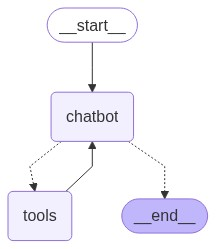

In [19]:
from IPython.display import Image, display, Markdown

display(Image(graph.get_graph().draw_mermaid_png()))

Let's test out our agent now

In [20]:
prompt = """What is the fastest animal on land?"""
response = graph.invoke({"messages": ("user", prompt)})
display(Markdown(response['messages'][-1].content))

The fastest land animal is the cheetah. It can reach speeds of up to 60 to 70 miles per hour (97 to 113 kilometers per hour) in short bursts covering distances up to 1,500 feet (460 meters), and it can accelerate from 0 to 60 miles per hour in just a few seconds.

In [21]:
response

{'messages': [HumanMessage(content='What is the fastest animal on land?', id='fae9b595-a054-43d6-bcc7-0d8d078e37b0'),
  AIMessage(content='The fastest land animal is the cheetah. It can reach speeds of up to 60 to 70 miles per hour (97 to 113 kilometers per hour) in short bursts covering distances up to 1,500 feet (460 meters), and it can accelerate from 0 to 60 miles per hour in just a few seconds.', response_metadata={'token_usage': {'completion_tokens': 70, 'prompt_tokens': 75, 'total_tokens': 145, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_07871e2ad8', 'finish_reason': 'stop', 'logprobs': None}, id='run-e72e59f4-30ae-4c45-a89d-94bc9c1ff3db-0')]}

In [22]:
prompt = """What is langraph?"""
response = graph.invoke({"messages": ("user", prompt)})
display(Markdown(response['messages'][-1].content))

Langraph is an advanced, scalable solution for building AI systems that require both information retrieval and language generation. It integrates techniques like Retrieval-Augmented Generation (RAG) to improve the quality of responses while scaling for large datasets. Langraph is designed to bridge the gap between traditional rule-based systems and modern, data-driven approaches like Large Language Models (LLMs). It enables the development of advanced AI agents capable of understanding, processing, and generating human language in a structured, meaningful way.

Langraph is part of the LangChain ecosystem and provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured manner. It simplifies the development process by enabling the creation of cyclical graphs, which are essential for developing agent runtimes. This makes it suitable for applications requiring autonomous decision-making, such as automated customer support, data processing, and system monitoring.

In [23]:
response

{'messages': [HumanMessage(content='What is langraph?', id='b8e6e110-364c-4627-8a6d-bbf157b4de1f'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_NSMVNSX8JKOfKjpD52dsWz3e', 'function': {'arguments': '{"query":"langraph"}', 'name': 'search_web'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 72, 'total_tokens': 87, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_07871e2ad8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-661db01c-ec56-4aaf-b88a-8290d03d41ce-0', tool_calls=[{'name': 'search_web', 'args': {'query': 'langraph'}, 'id': 'call_NSMVNSX8JKOfKjpD52dsWz3e', 'type': 'tool_call'}]),
  ToolMessage(content='[{"url": "https://medium.com/@jagadeesan.ganesh/a-comprehensive-guide-to-langraph-ste

### Build the Agentic Graph with LangGraph built-ins

Here we will use LangGraph to build the full graph which will have the Agentic workflow.

Each functionality will be implemented as we would in the real-world.

Here we will be replacing our `BasicToolNode` for the prebuilt [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode),
and our `route_tools` condition with the prebuilt [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition)

In [24]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

# define function which will be used to store all agent messages
class State(TypedDict):
    messages: Annotated[list, add_messages]

# start the graph building
graph_builder = StateGraph(State)

# add tools and bind to LLM
tools = [search_web, get_weather]
llm = ChatOpenAI(model="gpt-4o", temperature=0)
llm_with_tools = llm.bind_tools(tools)

# add the LLM to graph
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

# Add tools to a node
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# add conditional edges
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {'tools': 'tools', '__end__': '__end__'}
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
# Define entry point to the graph
graph_builder.set_entry_point("chatbot")
# compile the graph
graph = graph_builder.compile()

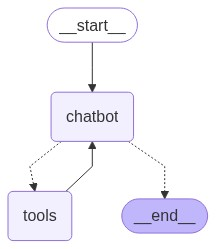

In [25]:
from IPython.display import Image, display, Markdown

display(Image(graph.get_graph().draw_mermaid_png()))

In [28]:
prompt = """What is the weather in bangalore?
show detailed statistics"""
response = graph.invoke({"messages": ("user", prompt)})
display(Markdown(response['messages'][-1].content))

The current weather in Bangalore, Karnataka, India is as follows:

- **Temperature**: 27.4°C (81.3°F)
- **Condition**: Partly cloudy
- **Wind**: 16.8 mph (27.0 kph) from the west-southwest (WSW) at 248°
- **Pressure**: 1008.0 mb (29.77 in)
- **Precipitation**: 0.02 mm (0.0 in)
- **Humidity**: 79%
- **Cloud Cover**: 75%
- **Feels Like**: 32.3°C (90.1°F)
- **Wind Chill**: 20.8°C (69.4°F)
- **Heat Index**: 20.8°C (69.4°F)
- **Dew Point**: 18.8°C (65.8°F)
- **Visibility**: 6.0 km (3.0 miles)
- **UV Index**: 2.1
- **Wind Gusts**: 22.7 mph (36.5 kph)

The local time in Bangalore is 15:08 on May 30, 2025.

In [29]:
prompt = """What is the weather in dubai? show detailed statistics"""
response = graph.invoke({"messages": ("user", prompt)})
display(Markdown(response['messages'][-1].content))

The current weather in Dubai is sunny. Here are the detailed statistics:

- **Temperature**: 40.3°C (104.5°F)
- **Feels Like**: 42.3°C (108.1°F)
- **Condition**: Sunny ![Sunny Icon](https://cdn.weatherapi.com/weather/64x64/day/113.png)
- **Wind**: 13.6 mph (22.0 kph) from the west (273°)
- **Wind Gusts**: Up to 28.7 mph (46.1 kph)
- **Humidity**: 32%
- **Pressure**: 999.0 mb (29.5 in)
- **Precipitation**: 0.0 mm (0.0 in)
- **Cloud Cover**: 0%
- **Visibility**: 10.0 km (6.0 miles)
- **UV Index**: 11.1 (Very High)
- **Dew Point**: 22.2°C (71.9°F)

The weather is quite hot and sunny, with a high UV index, so it's advisable to take precautions if you're planning to be outdoors.

In [30]:
prompt = """Which city is hotter?"""
response = graph.invoke({"messages": ("user", prompt)})
display(Markdown(response['messages'][-1].content))

To determine which city is hotter, I need to know the names of the cities you're interested in comparing. Could you please provide those?

We have successfully built an AI Agent which can search the web, get weather for us but it is not yet conversational. We will add in the that functionality in Part III next.

## Part III: Build a multi-user conversational ReAct Agent with LangGraph

Now, we will build a multi-user conversational ReAct agent with LangGraph which will use the web search or weather tool based on our input prompts to get relevant data which the LLM might not know by default and give relevant responses

Our agentic chatbot from Part II can use tools to answer user questions, but it doesn't remember the context of previous interactions. This limits its ability to have coherent, multi-turn conversations.

LangGraph solves this problem through **persistent checkpointing**. If you provide a `checkpointer` when compiling the graph and a `thread_id` when calling your graph, LangGraph automatically saves the state after each step. When you invoke the graph again using the same `thread_id`, the graph loads its saved state, allowing the chatbot to pick up where it left off.

**checkpointing** is _much_ more powerful than simple chat memory - it lets you save and resume complex state at any time for error recovery, human-in-the-loop workflows, time travel interactions, and more

While the legacy syntax uses `session_id`, in LangGraph, each user session is identified by `thread_id`

We will use `SqliteSaver` which helps to store separate conversation histories per user or session.

This will help us build a conversational Agentic Chatbot which will be accessed by many users at the same time.



In [31]:
# removes the memory database file - usually not needed
# you can run this only when you want to remove ALL conversation histories
# ok if you get rm: cannot remove 'memory.db': No such file or directory  because initially no memory exists
!rm memory.db*

rm: cannot remove 'memory.db*': No such file or directory


In [32]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.sqlite import SqliteSaver

# used to retrieve conversation history from database
# based on a specific user or session ID  - thread_id
memory = SqliteSaver.from_conn_string("memory.db")

# define function which will be used to store all agent messages
class State(TypedDict):
    messages: Annotated[list, add_messages]

# start the graph building
graph_builder = StateGraph(State)

# add tools and bind to LLM
tools = [search_web, get_weather]
llm = ChatOpenAI(model="gpt-4o", temperature=0)
llm_with_tools = llm.bind_tools(tools)

# add the LLM to graph
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

# Add tools to a node
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# add conditional edges
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    # either goes to tool node if tool calls or else end node
    {'tools': 'tools', '__end__': '__end__'}
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
# Define entry point to the graph
graph_builder.set_entry_point("chatbot")
# compile the graph - Add the memory here
graph = graph_builder.compile(checkpointer=memory)

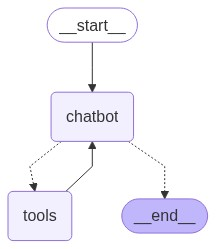

In [33]:
from IPython.display import Image, display, Markdown

display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:
def chat_with_agent(prompt: str, session_id: str):
    response = graph.invoke({"messages": [('user', prompt)]},
                                      {'configurable': { 'thread_id': session_id}})
    display(Markdown(response['messages'][-1].content))

Let's now simulate User 1 using the agent

In [35]:
user_id = 'jack001'
prompt = "Tell me about langraph"
chat_with_agent(prompt, user_id)

Langraph is an advanced framework designed for building AI systems that require both information retrieval and language generation. It integrates Retrieval-Augmented Generation (RAG) techniques to enhance the quality of responses and is scalable for large datasets. Langraph is particularly useful for developing chatbots, virtual assistants, and large-scale search engines.

Key features of Langraph include:

1. **AI Agent Framework**: Langraph provides a framework for creating, deploying, and managing complex generative AI agent workflows. It uses graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow.

2. **Scalability and Efficiency**: It allows users to create, run, and optimize large language models (LLMs) efficiently. The graph-based architecture enables scaling of AI workflows without compromising on speed or efficiency.

3. **Stateful Orchestration**: Langraph offers a stateful orchestration framework that provides added control to agent workflows. This includes a platform for deploying and scaling applications with an opinionated API for building agent user experiences.

4. **Applications**: Langraph is used in various applications, including robotics, autonomous vehicles, and video games. It also supports the development of sophisticated AI models that learn and improve over time.

5. **Developer Tools**: Langraph provides SDKs in Python and JavaScript, along with a developer studio for building and deploying applications.

Overall, Langraph is a powerful tool for developers looking to build reliable and scalable AI agents across different industries.

In [36]:
prompt = "What is it used for?"
chat_with_agent(prompt, user_id)

Langraph is used for developing advanced AI systems and applications that require complex interactions between humans and AI agents. Here are some specific use cases:

1. **Chatbots and Virtual Assistants**: Langraph can be used to build intelligent chatbots and virtual assistants that understand, process, and generate human language in a meaningful way.

2. **Large-Scale Search Engines**: It helps in creating search engines that can efficiently retrieve and generate information from large datasets.

3. **Agent-Based Systems**: Langraph provides a framework for building agent-based systems used in applications such as robotics, autonomous vehicles, and video games.

4. **Generative AI Workflows**: It is used to create, deploy, and manage complex generative AI workflows, allowing for the development of sophisticated AI models that can learn and improve over time.

5. **Personalized User Experiences**: By leveraging its capabilities, Langraph can be used to develop AI solutions that offer improved and personalized experiences, such as those used in customer service or hospitality industries.

6. **Scalable AI Applications**: Langraph's graph-based architecture allows for the scaling of AI workflows, making it suitable for applications that require high performance and efficiency.

Overall, Langraph is a versatile tool for developers aiming to build reliable, scalable, and intelligent AI agents across various industries.

Let's now simulate User 2 using the agent

In [37]:
user_id = 'bond007'
prompt = "how is the weather in Bangalore today? Show detailed statistics"
chat_with_agent(prompt, user_id)

The current weather in Bangalore is as follows:

- **Temperature**: 27.4°C (81.3°F)
- **Condition**: Partly cloudy ![Partly cloudy](https://cdn.weatherapi.com/weather/64x64/day/116.png)
- **Feels Like**: 32.3°C (90.1°F)
- **Wind**: 16.8 mph (27.0 kph) from the WSW (248°)
- **Gusts**: Up to 22.7 mph (36.5 kph)
- **Pressure**: 1008.0 mb (29.77 in)
- **Precipitation**: 0.02 mm
- **Humidity**: 79%
- **Cloud Cover**: 75%
- **Visibility**: 6.0 km (3.0 miles)
- **UV Index**: 2.1
- **Dew Point**: 18.8°C (65.8°F)

The weather is partly cloudy with a moderate breeze from the west-southwest.

In [38]:
user_id = 'bond007'
prompt = "what about Dubai?"
chat_with_agent(prompt, user_id)

The current weather in Dubai is as follows:

- **Temperature**: 40.3°C (104.5°F)
- **Condition**: Sunny ![Sunny](https://cdn.weatherapi.com/weather/64x64/day/113.png)
- **Feels Like**: 42.3°C (108.1°F)
- **Wind**: 13.6 mph (22.0 kph) from the W (273°)
- **Gusts**: Up to 28.7 mph (46.1 kph)
- **Pressure**: 999.0 mb (29.5 in)
- **Precipitation**: 0.0 mm
- **Humidity**: 32%
- **Cloud Cover**: 0%
- **Visibility**: 10.0 km (6.0 miles)
- **UV Index**: 11.1
- **Dew Point**: 22.2°C (71.9°F)

The weather is sunny with a warm breeze from the west. The UV index is very high, so sun protection is recommended.

In [39]:
user_id = 'bond007'
prompt = "which city is hotter?"
chat_with_agent(prompt, user_id)

Dubai is hotter than Bangalore. The current temperature in Dubai is 40.3°C (104.5°F), while in Bangalore, it is 27.4°C (81.3°F).